In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with protein folding

### Introduction

The structure and function of many natural and human-engineered
proteins are still only poorly understood. As a result, our knowledge of
processes connected with protein folding, such as those encountered in
Alzheimer’s disease, vaccine development, and crop improvement
research, has remained limited.

Unfolded polypeptides have a very large number of degrees of freedom
and thus an enormous number of potential conformations. For example, a
chain with $100$ amino acids has on the order of $10^{47}$ conformations. In
reality, however, many proteins fold to their native structure within
seconds. This is known as Levinthal’s paradox.<sup>1</sup>

The exponential growth of potential conformations with increased chain length
makes the problem intractable for classical computers. In the quantum
framework, our resource-efficient algorithm scales linearly with
the number of amino acids $N$.

The goal of this work is to determine the minimum-energy conformation of a protein. Starting from a random configuration, the protein’s structure is optimized to lower the energy. This can be achieved by encoding the protein folding problem into a qubit operator and ensuring that all physical constraints are satisfied. 

Here we use a coarse-grained model suited for the description of branched heteropolymers composed of $N$ monomers on a tetrahedral (or diamond) lattice. 
A two-centered coarse-grained description of amino acid comprised of backbone and side chain was chosen given the current resources of actual quantum devices.
Finally, every monomer is represented by one or multiple beads having a defined color shade corresponding to its physical properties.

For the problem encoding we use: 

#### The configuration qubits

A polymer configuration is grown on the lattice by inserting the different beads sequentially, where the relative position of different beads $i$ and $i+1$ are described by the “turn” $t_i$ and encoded in the qubit register.
In a tetrahedral lattice, two sets of nonequivalent lattice points *A* and *B* can be identified (see the figure below).
*A* and *B* lattice points are alternated, giving a convention that *A* (or *B*) sites have even (odd) $i$s.
To encode the turns, one qubit per axis is required, so the total number of required qubits to encode a conformation $\mathbf{q}_{cf}$ is $N_{cf}=4(N-3)$, where $N$ is the number of beads in the polymer.
A denser encoding requiring only $2(N-3)$ is also possible.


#### The interaction qubits

The interactions between beads are encoded in a qubit register $\mathbf{q}_{in}$, having $q_{i,j}^{(l)}$ for each $l^{th}$ nearest-neighbor ($l$-NN) interaction on the lattice.
The number of qubits for the interaction register $N_{in}$ is determined by the skeleton of the polymer, and it scales as $O(N^2)$.
A pairwise interaction energy $\epsilon_{i,j}^{(l)}$ at distance $l$ can be defined in many ways, and here we use the potential proposed in Miyazawa and Jernigan 2016.<sup>2</sup>

<img src="lattice_protein.png" width="500">

#### The Hamiltonian

The Hamiltonian of the system represents the energy of a given fold that is defined by the sequence of beads and the encoded turns.
Penalty terms are used to impose physical constraints, and
the interaction energies are applied when two beads occupy neighboring sites or are at distance $l>1$, where $l$ is the length of the shortest lattice path connecting them.
The Hamiltonian for a set of qubits $\mathbf{q}=\{\mathbf{q}_{cf}, \mathbf{q}_{in}\}$ is 

$$H(\mathbf{q}) = H_{gc}(\mathbf{q}_{cf}) + H_{ch}(\mathbf{q}_{cf}) + H_{in}(\mathbf{q}_{cf}, \mathbf{q}_{in}) $$

where 

- $H_{gc}$ is the geometrical constraint term (governing the growth of the primary sequence of amino acids without bifurcations).

- $H_{ch}$ is the chirality constraint (enforcing the right stereochemistry for the system).

- $H_{in}$ denotes the interaction energy terms of the system. In our case, we consider only nearest-neighbor interactions.

Further details about this model and the encoding of the problem can be found in Robert et al. 2021.<sup>3</sup>

In [2]:
from qiskit_research.protein_folding.interactions.random_interaction import (
    RandomInteraction,
)
from qiskit_research.protein_folding.interactions.miyazawa_jernigan_interaction import (
    MiyazawaJerniganInteraction,
)
from qiskit_research.protein_folding.peptide.peptide import Peptide
from qiskit_research.protein_folding.protein_folding_problem import (
    ProteinFoldingProblem,
)

from qiskit_research.protein_folding.penalty_parameters import PenaltyParameters

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 23

### Protein main chain

The system of interest is a neuropeptide consisting of a linear chain of seven amino acids with letter codes `APRLRFY`. We demonstrate the generation of the qubit operator for this protein. For a refresher of the naming convention of residues, see Refs. [[4]](#Naming) and [[5]](#AminoAcid).

In [3]:
main_chain = "APRLRFY"

### Side chains

Beyond the main chain of the protein there may be amino acids attached to the residues of the main chain. Our model allows for side chains of the maximum length of $1$. Elongated side chains would require the introduction of additional penalty terms that are still under development. In this example, we do not consider any side chains to keep the real structure of the neuropeptide. 

In [4]:
side_chains = [""] * 7

### Interaction between amino acids

To describe the inter-residue contacts for proteins, we use knowledge-based (statistical) potentials derived from quasi-chemical approximation. The potentials used here are introduced by Miyazawa and Jernigan 1996.<sup>2</sup>

Beyond this model, we also allow for random contact maps (interactions) that provide a random interaction map. One can also introduce a custom interaction map that enhances secondary structures of the protein, such as alpha helices and beta sheets. 

In [5]:
random_interaction = RandomInteraction()
mj_interaction = MiyazawaJerniganInteraction()

### Physical constraints

To ensure that all physical constraints are respected, we introduce penalty functions. The different penalty terms are: 

- `penalty_chiral`: A penalty parameter used to impose the right chirality.

- `penalty_back`: A penalty parameter used to penalize turns along the same axis. This term is used to eliminate sequences where the same axis is chosen twice in a row. In this way, we do not allow for a chain to fold back into itself.

- `penalty_1`: A penalty parameter used to penalize local overlap between beads within a nearest-neighbor contact.

In [6]:
penalty_back = 10
penalty_chiral = 10
penalty_1 = 10

penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)

### Peptide definition


Based on the main chain and possible side chains, we define the peptide object that includes all the structural information of the modeled system.

In [7]:
peptide = Peptide(main_chain, side_chains)

### Protein folding problem 

Based on the defined peptide, the interaction (contact map), and the penalty terms we defined for our model, we now define the protein folding problem that returns qubit operators.


In [8]:
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

In [9]:
print(qubit_op)

1613.5895000000003 * IIIIIIIII
+ 487.5 * IIIIIIZII
- 192.5 * IIIIIIIZZ
+ 192.5 * IIIIIIZZZ
- 195.0 * IIIIZIZII
- 195.0 * IIIIIZIZI
- 195.0 * IIIIZZZZI
- 95.0 * IIZIZIIII
- 95.0 * IIIZIZIII
- 95.0 * IIZZZZIII
+ 295.0 * IIIIIIZZI
- 497.5 * IIIIZIIII
- 300.0 * IIIIZZIII
+ 195.0 * IIIIIIIIZ
+ 197.5 * IIIIIZIIZ
- 197.5 * IIIIZZIIZ
- 904.2875 * IZIIIIIII
- 295.0 * IZIIIIZII
- 197.5 * IZIIIIZZI
+ 302.5 * IZIIZIIII
+ 202.5 * IZIIZZIII
+ 100.0 * IZIIZIZII
+ 100.0 * IZIIIZIZI
+ 100.0 * IZIIZZZZI
- 200.0 * IZIIIIIIZ
+ 97.5 * IZIIIIIZZ
- 97.5 * IZIIIIZZZ
- 100.0 * IZIIIZIIZ
+ 100.0 * IZIIZZIIZ
+ 100.0 * IIIIIIIZI
- 100.0 * IIIIIZIII
+ 2.5 * IZIIIIIZI
- 2.5 * IZIIIZIII
+ 192.5 * IIZIIIIII
+ 95.0 * IIZZIIIII
+ 97.5 * IIZIIIZII
+ 97.5 * IIIZIIIZI
+ 97.5 * IIZZIIZZI
- 97.5 * IIIZIIIIZ
+ 97.5 * IIZZIIIIZ
+ 7.5 * IZZIIIIII
+ 5.0 * IZZZIIIII
+ 2.5 * IZZIIIZII
+ 2.5 * IZIZIIIZI
+ 2.5 * IZZZIIZZI
- 2.5 * IZZIZIIII
- 2.5 * IZIZIZIII
- 2.5 * IZZZZZIII
- 2.5 * IZIZIIIIZ
+ 2.5 * IZZZIIIIZ
+ 105.0 * IIIZIIIII
-

### Using VQE with CVaR expectation value for the solution of the problem

The problem has now implemented all the physical constraints and has a diagonal Hamiltonian. In this particular case, we are targeting the single bit string that gives us the minimum energy (corresponding to the folded structure of the protein). We can therefore use the variational quantum eigensolver (VQE) with conditional value-at-risk (CVaR) expectation values to solve the problem and to find the minimum configuration energy.<sup>6</sup> We follow the same approach as in Miyazawa and Jernigan 1996,<sup>2</sup> but here we use COBYLA for the classical optimization part. One can also use the standard VQE or QAOA algorithm for the solution, though as discussed in Miyazawa and Jernigan 1996,<sup>2</sup> CVaR is more suitable. 

In [10]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.primitives import Sampler

# set classical optimizer
optimizer = COBYLA(maxiter=50)

# set variational ansatz
ansatz = RealAmplitudes(reps=1)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


# initialize VQE using CVaR with alpha = 0.1
vqe = SamplingVQE(
    Sampler(),
    ansatz=ansatz,
    optimizer=optimizer,
    aggregation=0.1,
    callback=store_intermediate_result,
)

raw_result = vqe.compute_minimum_eigenvalue(qubit_op)
print(raw_result)

SamplingMinimumEigensolverResult:
	Eigenvalue: -1.396058817404514
	Best measurement
: {'state': 165, 'bitstring': '010100101', 'value': (-1.4249999999996135+0j), 'probability': 0.0012630027202188}



/Users/lcd/github/gbs-ibm-q/fixes/asset-lib-code-base/Algorithm Demos/Protein folding/test-env/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/lcd/github/gbs-ibm-q/fixes/asset-lib-code-base/Algorithm Demos/Protein folding/test-env/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


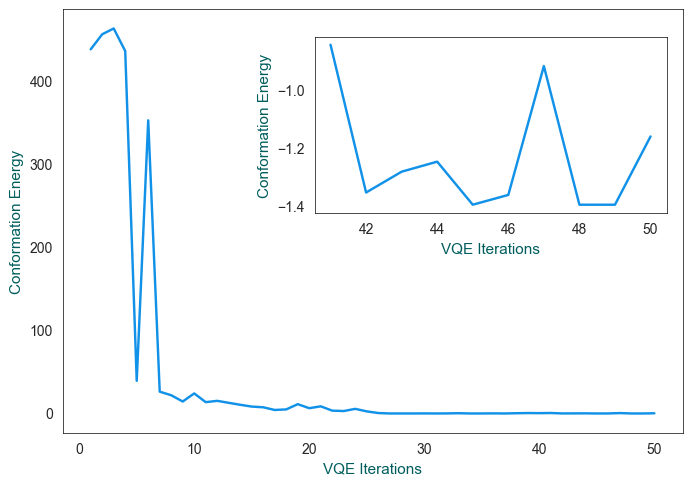

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

fig.add_axes([0.44, 0.51, 0.44, 0.32])

plt.plot(counts[40:], values[40:])
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")
plt.show()

### Visualizing the answer

In order to lower computational costs, we have reduced the problem’s qubit operator to the minimum number of qubits needed to represent the shape of the protein. To decode the answer, we need to understand how this has been done.
* The shape of the protein has been encoded by a sequence of turns, $\{0,1,2,3\}$. Each turn represents a different direction in the lattice.
* For a main bead of $N_{aminoacids}$ in a lattice, we need $N_{aminoacids}-1$ turns in order to represent its shape. However, the orientation of the protein is not relevant to its energy. Therefore, the first two turns of the shape can be set to $[1,0]$ without loss of generality.
* If the second bead does not have any side chain, we can also set the $6^{th}$ qubit to $[1]$ without breaking symmetry.
* Since the length of the secondary chains is always limited to $1$, we need only one turn to describe the shape of the chain.

The total number of qubits we need to represent the shape of the protein will be $2(N_{aminoacids}-3)$ if there is a secondary chain coming out of the second bead, or $2(N_{aminoacids}-3) - 1$ otherwise. All the other qubits will remain unused during the optimization process. 

In [12]:
result = protein_folding_problem.interpret(raw_result=raw_result)
print(
    "The bitstring representing the shape of the protein during optimization is: ",
    result.turn_sequence,
)
print("The expanded expression is:", result.get_result_binary_vector())

The bitstring representing the shape of the protein during optimization is:  101100011
The expanded expression is: 1______0_____________________________________________________________________________________________________________________________110001_1____


There are 9 qubits needed to represent the shape of the protein: 7 configuration qubits and 2 interaction qubits. 

Now that we know which qubits encode which information, we can decode the bit string into the explicit turns that form the shape of the protein.

In [13]:
print(f"The folded protein's main sequence of turns is: {result.protein_shape_decoder.main_turns}"
)
print(f"and the side turn sequences are: {result.protein_shape_decoder.side_turns}")

The folded protein's main sequence of turns is: [1, 0, 3, 2, 0, 3]
and the side turn sequences are: [None, None, None, None, None, None, None]


From this sequence of turns we can get the Cartesian coordinates of each of the protein’s amino acids.

In [14]:
print(result.protein_shape_file_gen.get_xyz_data())

[['A' '0.0' '0.0' '0.0']
 ['P' '0.5773502691896258' '0.5773502691896258' '-0.5773502691896258']
 ['R' '1.1547005383792517' '0.0' '-1.1547005383792517']
 ['L' '1.7320508075688776' '-0.5773502691896258' '-0.5773502691896258']
 ['R' '2.3094010767585034' '0.0' '0.0']
 ['F' '1.7320508075688776' '0.5773502691896258' '0.5773502691896258']
 ['Y' '1.154700538379252' '1.1547005383792517' '0.0']]


Finally, we can plot the structure of the protein in 3D. Note that when rendered with the proper backend, this plot can be interactively rotated.

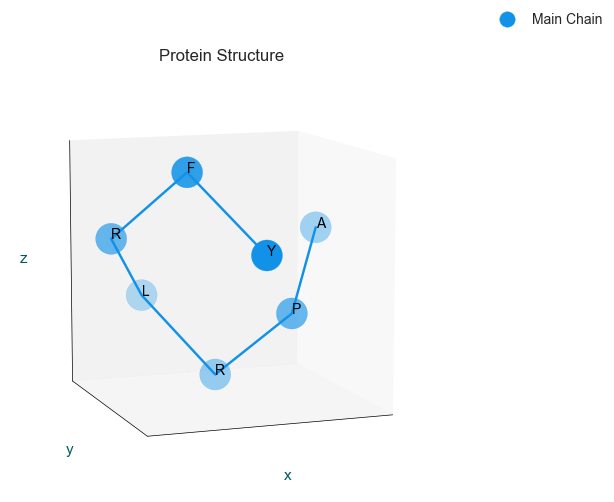

In [15]:
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)

Here is an example with side chains.

In [16]:
peptide = Peptide("APRLR", ["", "", "F", "Y", ""])
protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

# set classical optimizer
optimizer = COBYLA(maxiter=50)

# set variational ansatz
ansatz = RealAmplitudes(reps=1)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


# initialize VQE using CVaR with alpha = 0.1
vqe = SamplingVQE(
    Sampler(),
    ansatz=ansatz,
    optimizer=optimizer,
    aggregation=0.1,
    callback=store_intermediate_result,
)

raw_result = vqe.compute_minimum_eigenvalue(qubit_op)
result_2 = protein_folding_problem.interpret(raw_result=raw_result)

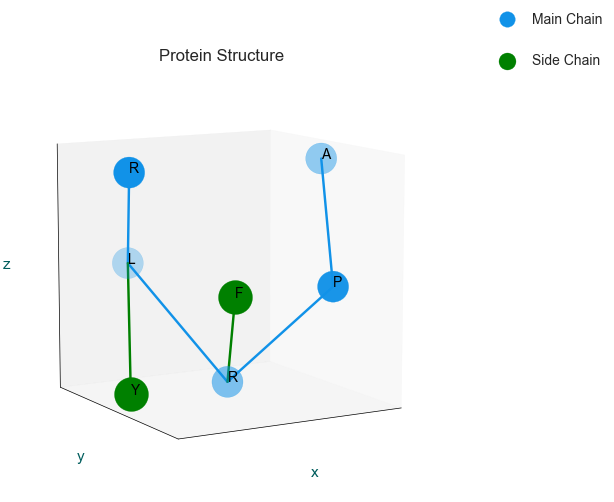

In [17]:
fig = result_2.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 60)

### Summary

The quantum algorithm for protein folding presented in this notebook opens up the potential to explore this interesting problem using quantum computers. The algorithm can be further extended by providing a better and more realistic representation of amino acid side chains and a better description of long-range interactions.

### References
1. <a id='Levinthal'></a>“Levinthal’s paradox.” *Wikipedia*. [https://en.wikipedia.org/wiki/Levinthal%27s_paradox](https://en.wikipedia.org/wiki/Levinthal%27s_paradox).

2. <a id='Miyazawa1996'></a>Sanzo Miyazawa and Robert L. Jernigan. “Residue – Residue Potentials with a Favorable Contact Pair Term and an Unfavorable High Packing Density Term for Simulation and Threading.” *Journal of Molecular Biology*, vol. 256, no. 3 (1996): 623–644. [https://doi.org/10.1006/jmbi.1996.0114](https://doi.org/10.1006/jmbi.1996.0114).

3. <a id='RobertA2021'></a>Anton Robert et al. “Resource-Efficient Quantum Algorithm for Protein Folding,” *npj Quantum Information*, vol. 7 (2021). [https://doi.org/10.1038/s41534-021-00368-4](https://doi.org/10.1038/s41534-021-00368-4).

4. <a id='Naming'></a>IUPAC–IUB Commission on Biochemical Nomenclature. “A One-Letter Notation for Amino Acid Sequences.” *Pure and Applied Chemistry*, vol. 31, no. 4 (1972): 641–645. [https://doi.org/10.1351/pac197231040639](https://doi.org/10.1351/pac197231040639).

5. <a id='AminoAcid'></a>“Amino Acid.” *Wikipedia*. [https://en.wikipedia.org/wiki/Amino_acid](https://en.wikipedia.org/wiki/Amino_acid).

6. <a id='Barkoutsos2020'></a>Panagiotis K. Barkoutsos et al., “Improving Variational Quantum Optimization Using CVaR.” *Quantum*, vol. 4, no. 256 (2020). [https://doi.org/10.22331/q-2020-04-20-256](https://doi.org/10.22331/q-2020-04-20-256).


<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>